In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

<b> Загрузка и предобработка исходных данных

In [4]:
data = pd.read_csv("../../Практические материалы/Lab 1. Linear and logistic regression/mnist/mnist_train.csv")
data_test = pd.read_csv("../../Практические материалы/Lab 1. Linear and logistic regression/mnist/mnist_test.csv")

In [5]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X = data.iloc[:,1:].values
X_test = data_test.iloc[:,1:].values

In [7]:
mean = np.mean(X)
std = np.std(X)

X = (X - mean)/std
X_test = (X_test - mean)/std

In [8]:
m = len(X)
n = 10

Y = np.zeros([m,n])

for i in range(m):
    Y[i,data.label.values[i]] = 1

In [9]:
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [10]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [11]:
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

In [12]:
def relu(z):
    return np.max(0,z)

In [13]:
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z), axis = 1).reshape([len(z),1])

In [14]:
def conv(z, filters, padding = 1):
    height = z.shape[0]
    width = z.shape[1]
    depth = z.shape[2]
    samples = z.shape[3]
    n = filters.shape[0]
    m = filters.shape[1]
    l = filters.shape[2]
    n_filters = filters.shape[3]
    
    z_pad = np.zeros([height+padding*2,width+padding*2,depth,samples])
    if padding > 0:
        z_pad[padding:-padding,padding:-padding,:,:] = z[:,:,:,:]
    else:
        z_pad = z
    
    output_h = height + padding * 2 - (n - 1)
    output_w = width + padding * 2 - (n - 1)
    result = np.zeros([output_h,output_w,n_filters,samples])
    
    for s in range(samples):
        for k in range(n_filters):
            for i in range(output_h):
                for j in range(output_w):
                    result[i,j,k,s] = np.sum(z_pad[i:i+n,j:j+m,0:l,s]*filters[:,:,:,k])

    return result

In [15]:
def max_pool(z, pool_size):
    height = z.shape[0]
    width = z.shape[1]
    depth = z.shape[2]
    samples = z.shape[3]
    
    h2 = (pool_size - height%pool_size)%pool_size
    w2 = (pool_size - width%pool_size)%pool_size
        
    z_pad = np.zeros([height+h2,width+w2,depth,samples])
    z_pad[:height,:width,:,:] = z

    result = np.zeros([(height+h2)//pool_size,(width+w2)//pool_size,depth,samples])
        
    for s in range(samples):    
        for k in range(depth):
            for i in range(0,height+h2,pool_size):
                for j in range(0,width+w2,pool_size):
                    tmp = z_pad[i:i+pool_size,j:j+pool_size,k,s]
                    result[i//pool_size,j//pool_size,k,s] = np.max(tmp)
                    
    return result

In [16]:
def avg_pool(z, pool_size):
    height = z.shape[0]
    width = z.shape[1]
    depth = z.shape[2]
    samples = z.shape[3]
    
    h2 = (pool_size - height%pool_size)%pool_size
    w2 = (pool_size - width%pool_size)%pool_size
        
    z_pad = np.zeros([height+h2,width+w2,depth,samples])
    z_pad[:height,:width,:,:] = z[:,:,:,:]

    result = np.zeros([(height+h2)//pool_size,(width+w2)//pool_size,depth,samples])
    
    for s in range(samples):
        for k in range(depth):
            for i in range(0,height+h2,pool_size):
                for j in range(0,width+w2,pool_size):
                    tmp = z_pad[i:i+pool_size,j:j+pool_size,k,s]
                    result[i//pool_size,j//pool_size,k,s] = np.mean(tmp)
                    
    return result

In [17]:
def flatten(z):
    dim0 = z.shape[0]
    dim1 = z.shape[1]
    dim2 = z.shape[2]
    dim3 = z.shape[3]
    
    result = np.zeros([dim3,dim0*dim1*dim2])
    
    for s in range(dim3):
        result[s,:] = z[:,:,:,s].flatten()
    
    return result

In [18]:
def d_conv(filters,f_prev,sigma,padding = 1):
    d_filters = np.zeros_like(filters)
    height = sigma.shape[0]
    width = sigma.shape[1]
    depth = sigma.shape[2]
    samples = sigma.shape[3]
    n = filters.shape[0]
    m = filters.shape[1]
    l = filters.shape[2]
    n_filters = filters.shape[3]
    
    f_prev_pad = np.zeros([f_prev.shape[0]+padding*2,f_prev.shape[1]+padding*2,f_prev.shape[2],f_prev.shape[3]])
    
    if padding > 0:
        f_prev_pad[padding:-padding,padding:-padding,:,:] = f_prev[:,:,:,:]
    else:
        f_prev_pad = f_prev
    
    #print(X)
    sigma_new = np.zeros_like(f_prev_pad)
    
    for s in range(samples):
        for k in range(n_filters):
            for i in range(height):
                for j in range(width):
                    d_filters[:,:,:,k] += f_prev_pad[i:i+n,j:j+m,0:l,s]*sigma[i,j,k,s]
                    sigma_new[i:i+n,j:j+m,0:l,s] += filters[:,:,:,k]*sigma[i,j,k,s]
                
    if padding > 0:
        sigma_new = sigma_new[padding:-padding,padding:-padding,:,:]
                
    return d_filters,sigma_new

In [19]:
def d_flat(z,size):
    dim0 = size[0]
    dim1 = size[1]
    dim2 = size[2]
    dim3 = size[3]
    
    result = np.zeros(size)
    
    for s in range(dim3):
        result[:,:,:,s] = z[s,:].reshape([dim0,dim1,dim2])
    
    return result

In [20]:
def d_max_pool(sigma,f_prev,pool_size):
    result = np.zeros([sigma.shape[0]*pool_size,sigma.shape[1]*pool_size,sigma.shape[2],sigma.shape[3]])

    for s in range(sigma.shape[3]):
        for k in range(sigma.shape[2]):
            for i in range(0,sigma.shape[0]*pool_size,pool_size):
                for j in range(0,sigma.shape[1]*pool_size,pool_size):
                    tmp = f_prev[i:i+pool_size,j:j+pool_size,k,s]
                    max_ind = np.argmax(tmp.flatten())
                    
                    result[i+max_ind//pool_size,j+max_ind%pool_size,k,s] = sigma[i//pool_size,j//pool_size,k,s]

    return result

In [21]:
def d_avg_pool(sigma,f_prev,pool_size):
    result = np.zeros([sigma.shape[0]*pool_size,sigma.shape[1]*pool_size,sigma.shape[2],sigma.shape[3]])

    for s in range(sigma.shape[3]):
        for k in range(sigma.shape[2]):
            for i in range(0,sigma.shape[0]*pool_size,pool_size):
                for j in range(0,sigma.shape[1]*pool_size,pool_size):
                    result[i:i+pool_size,j:j+pool_size,k,s] = sigma[i//pool_size,j//pool_size,k,s]

    return result/pool_size**2

In [22]:
def d_softmax(z,sigma):
    d_softmax = np.zeros([z.shape[1],z.shape[1],z.shape[0]])
    
    for k in range(z.shape[0]):
        for i in range(d_softmax.shape[0]):
            for j in range(d_softmax.shape[1]):
                if i == j:
                    d_softmax[i,j,k] += z[k,i]*(1-z[k,j])
                else:
                    d_softmax[i,j,k] += -z[k,i]*z[k,j]
    
    sigma_new = np.zeros_like(sigma)
    for k in range(z.shape[0]):
        sigma_new[k,:] = np.matmul(sigma[k:k+1,:],d_softmax[:,:,k]).flatten()
    
    return sigma_new

In [23]:
def forward(X,filters,W,B,pool_size):
    F0 = conv(X,filters[0],padding=2)
    F1 = tanh(F0)
    F2 = avg_pool(F1,pool_size)
    F3 = conv(F2,filters[1],padding=0)
    F4 = tanh(F3)
    F5 = avg_pool(F4,pool_size)
    F6 = conv(F5,filters[2],padding=0)
    F7 = tanh(F6)
    F8 = flatten(F7)
    F9 = tanh(np.matmul(F8,W[0]) + B[0])
    F10 = softmax(np.matmul(F9,W[1]) + B[1])
    
    return (F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10)

In [24]:
def backprop(X,F,W,Y,filters,pool_size):
    sigma = (F[10] - Y)/(F[10]*(1-F[10]))
    sigma = d_softmax(F[10],sigma)
    
    dW2 = np.matmul(F[9].T,sigma)
    dB2 = np.sum(sigma, axis = 0)
    
    sigma = np.matmul(sigma,W[1].T)
    sigma = sigma*(1-F[9]*F[9])
    
    dW1 = np.matmul(F[8].T,sigma)
    dB1 = np.sum(sigma, axis = 0)
    
    sigma = np.matmul(sigma,W[0].T)
    sigma = d_flat(sigma,F[7].shape)
    sigma = sigma*(1-F[7]*F[7])
    
    d_filters3,sigma = d_conv(filters[2],F[5],sigma,padding=0)
    sigma = d_avg_pool(sigma,F[4],pool_size)
    
    sigma = sigma*(1-F[4]*F[4])
    
    d_filters2,sigma = d_conv(filters[1],F[2],sigma,padding=0)
    sigma = d_avg_pool(sigma,F[1],pool_size) 
    
    sigma = sigma*(1-F[1]*F[1])
    d_filters1,sigma = d_conv(filters[0],X,sigma,padding=2)
    
    return (dW2,dB2,dW1,dB1,d_filters3,d_filters2,d_filters1)    

In [25]:
def init_vectors(w):
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    m_hat = np.zeros_like(w)
    v_hat = np.zeros_like(w)
    return [m,v,m_hat,v_hat]
    

In [26]:
def calc_grad(m_vector,grad,beta1,beta2,t):
    m_vector[0] = beta1*m_vector[0] + (1-beta1)*grad
    m_vector[1] = beta2*m_vector[1] + (1-beta2)*grad**2
    m_vector[2] = m_vector[0]/(1-beta1**t)
    m_vector[3] = m_vector[1]/(1-beta2**t)
    
    return m_vector
    

In [30]:
filters1 = np.random.randn(5,5,1,6)
filters2 = np.random.randn(5,5,6,16)
filters3 = np.random.randn(5,5,16,120)

filters = [filters1,filters2,filters3]

W1 = np.random.randn(120,84)
B1 = np.random.randn(1,84)
W2 = np.random.randn(84,10)
B2 = np.random.randn(1,10)

W = [W1,W2]
B = [B1,B2]

m_filters1 = init_vectors(filters1)
m_filters2 = init_vectors(filters2)
m_filters3 = init_vectors(filters3)

m_W1 = init_vectors(W1)
m_W2 = init_vectors(W2)
m_B1 = init_vectors(B1)
m_B2 = init_vectors(B2)


pool_size = 2

batch_size = 100

m = len(X)

alpha = 0.01

Js = []

beta1 = 0.9
beta2 = 0.999

X_test_batch = np.zeros([28,28,1,100])
for k in range(batch_size):
    X_test_batch[:,:,0,k] = X_test[k,:].reshape([28,28])
Y_test_batch = data_test.label.values[0:100]

for t in range(0,m,batch_size):
    X_batch = np.zeros([28,28,1,batch_size])
    for k in range(batch_size):
        X_batch[:,:,0,k] = X[t+k,:].reshape([28,28])
        
    Y_batch = Y[t:t+batch_size,:]
    F = forward(X_batch,filters,W,B,pool_size)
        
    J = -np.sum(Y_batch*np.log(F[-1])+(1-Y_batch)*np.log(1-F[-1]))
    Js.append(J)
    
    print(Js[-1], np.mean(Js[-15:]))
        
    grads = backprop(X_batch,F,W,Y_batch,filters,pool_size)
    
    m_W2 = calc_grad(m_W2,grads[0],beta1,beta2,t+1)
    m_B2 = calc_grad(m_B2,grads[1],beta1,beta2,t+1)
    m_W1 = calc_grad(m_W1,grads[2],beta1,beta2,t+1)
    m_B1 = calc_grad(m_B1,grads[3],beta1,beta2,t+1)
    m_filters3 = calc_grad(m_filters3,grads[4],beta1,beta2,t+1)
    m_filters2 = calc_grad(m_filters2,grads[5],beta1,beta2,t+1)
    m_filters1 = calc_grad(m_filters1,grads[6],beta1,beta2,t+1)
    
    W2 += -alpha*m_W2[2]/(np.sqrt(m_W2[3])+0.00001)
    B2 += -alpha*m_B2[2]/(np.sqrt(m_B2[3])+0.00001)
    W1 += -alpha*m_W1[2]/(np.sqrt(m_W1[3])+0.00001)
    B1 += -alpha*m_B1[2]/(np.sqrt(m_B1[3])+0.00001)
    filters3 += -alpha*m_filters3[2]/(np.sqrt(m_filters3[3])+0.00001)
    filters2 += -alpha*m_filters2[2]/(np.sqrt(m_filters2[3])+0.00001)
    filters1 += -alpha*m_filters1[2]/(np.sqrt(m_filters1[3])+0.00001)
    
    F = forward(X_test_batch,filters,W,B,pool_size)
    accuracy = np.mean(np.argmax(F[-1], axis=1) == Y_test_batch)
    print(accuracy)


1574.4593069204439 1574.4593069204439
0.12
1448.7983189899742 1511.628812955209
0.13
1579.4426871685762 1534.2334376929982
0.12
1468.1062343700642 1517.7016368622646
0.12
1131.5386439492272 1440.4690382796573
0.22
1136.347007325899 1389.7820331206976
0.28
1023.6202445692372 1337.4732061847749
0.32
847.9938001219197 1276.2882804269177
0.35
733.165715258119 1215.9413287414957
0.44
687.2161713797572 1163.0688130053218
0.38
717.2280357549134 1122.5378332552848
0.39
786.8913146270413 1094.5672900362645
0.37
970.8678867985941 1085.0519513256745
0.31
542.8492505597703 1046.3231869852527
0.44
607.1624338427127 1017.0458034424167
0.42
530.7808233623418 947.4672378718765
0.35
517.1783761734225 885.3592416841062
0.41
362.46244855537884 804.2272257765599
0.36


KeyboardInterrupt: 

In [31]:
F = forward(X_test_batch,filters,W,B,pool_size)

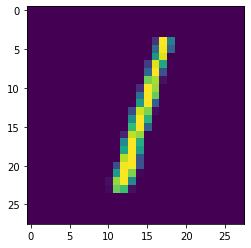

In [69]:
plt.imshow(X_test_batch[:,:,0,2])

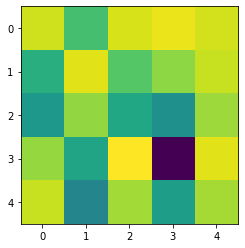

In [82]:
plt.imshow(np.log(np.abs(filters1[:,:,0,1])))

In [ ]:
Доделать производные других слоев

Обучить 1 итерацию сравнить ошибку с Keras для разных размеров батча

batch = 1

Сделать batch_normalization

Сделать dropout